# EfficientNet: small step for an optimizer gient giant leap datascientists
### **Data mining** | **Object detection** | **PyTorch** | **EfficientNet initializing** | **EfficientNet training** 

EfficientNet paper: [EfficientNet: Rethinking Model Scaling for Convolutional Neural Networks
](https://arxiv.org/pdf/1905.11946.pdf)

![graphics](https://i.ibb.co/k8TV0MM/image3.png)

https://ai.googleblog.com/2019/05/efficientnet-improving-accuracy-and.html
https://colab.research.google.com/drive/1ByRi9d6_Yzu0nrEKArmLMLuMaZjYfygO#scrollTo=mub8GJMBVluA
https://www.kaggle.com/shonenkov/inference-efficientdet
https://www.kaggle.com/shonenkov/training-efficientdet

**Huge thanks to [Alex Shonenkov](https://www.kaggle.com/shonenkov) for making so well-explaining notebooks**

### Hello!
In this notebook we're going to work through one of the most popular architectures for multiple object detection: EfficientNet. One must have read lots of notebooks, papers about this quite new and modern DL thing, but there are really few notebooks about **the whole** process of creating, training and using yolov3 in your projects. Due to the very complex architecture, EfficientNet (lots of convolution, maxpooling layers and huge output vectors) is very difficult even for modern hardware to be trained. One needs GPU accelerators, or even TPU so as to make training faster. But as far as you know, **transfer** learning is a widely-used technique, so here we are free to use treansfer learning too.

Lets divide our complex task into some subtasks, which must be easier to be solved:
1. *Data mining*. Here we need to find data(images) for training an EfficientNet of yours, but the data must be 'preprocessed'. So before using the data, you have to make sure, that all the images have bounding boxes and an appropriate class for all the boxes. [LabelImg](https://github.com/tzutalin/labelImg) is a useful open source project for it.
![](https://lh3.googleusercontent.com/proxy/OVFxl--wnKLg3QTcpb1wvH9twmERGcrQ2I7DZ3voTN3nKmOBvvzBSQWWVanPPnWJETahZV2LjpaevdidRJ65eWo)
<br>
2. *Builiding*. Having a nice dataset for object detection, you have to build an EfficientNet.
3. *Training*. Fit your specific dataset into the model.
4. (OPTIONAL)*User friendly*. Build a simple in->out functionality between user and your EfficientNet trained model, so that it'd be easy for you and someone else to just simply give an image to your model and get a bounding box(es) + class names.

## Data mining

I already have an idea to build an application for **OCR** [optical character recogniton](https://en.wikipedia.org/wiki/Optical_character_recognition) problem with my own huge dataset. You may have taken another problem. So if anyone asks for deeper explanations, I'll be pleased to share with you the whole process.

*** Import appropriate libraries for data**

In [59]:
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
from random import sample
from colorama import Fore, Style

In [60]:
TRAIN_FOLDER = '../input/charaters-for-detection-classification/csvdata/'

marking = pd.read_csv(os.path.join(TRAIN_FOLDER, 'train.csv'))
#DEBUG#
marking['source'] = ['' for i in range(len(marking['image_id']))]
#DEBUG#
TRAIN_IMGS_FOLDER = os.path.join(TRAIN_FOLDER, 'images')
print(f'NUMBER OF TRAINING EXAMPLES{Fore.BLUE}', len(os.listdir(TRAIN_IMGS_FOLDER)),f'{Style.RESET_ALL}')

NUMBER OF TRAINING EXAMPLES 10483 


In [61]:
######################### BBOXS ERROR ###############################
import numpy as np
bboxs = np.stack(marking['bbox'].apply(lambda x: np.fromstring(x[1:-1], sep=' ')))
bad_idxs = []
print('before:', len(marking))
print(marking.shape)
for i, bbox in enumerate(bboxs):
    if bbox[0] + bbox[2] > 255 or bbox[1] + bbox[3] > 255:
        bad_idxs.append(i)
marking = marking.drop(bad_idxs)
print('after:', len(marking))
print(marking.shape)
#####################################################################

before: 46967
(46967, 5)
after: 46640
(46640, 5)


For my problem, I made a program for generating background and a random character with different colours so as to avoid anomalies in dataset. Let me show you what it looks like...

In [62]:
num_examples = 6
example_images = [os.path.join(TRAIN_IMGS_FOLDER, file) for file in sample(os.listdir(TRAIN_IMGS_FOLDER), num_examples)]

In [63]:
img_for_shape = cv2.imread(example_images[0])
IMG_WIDTH, IMG_HEIGHT = img_for_shape.shape[0],img_for_shape.shape[1]
print('image width=', IMG_WIDTH,'; image height=', IMG_HEIGHT)

image width= 256 ; image height= 256


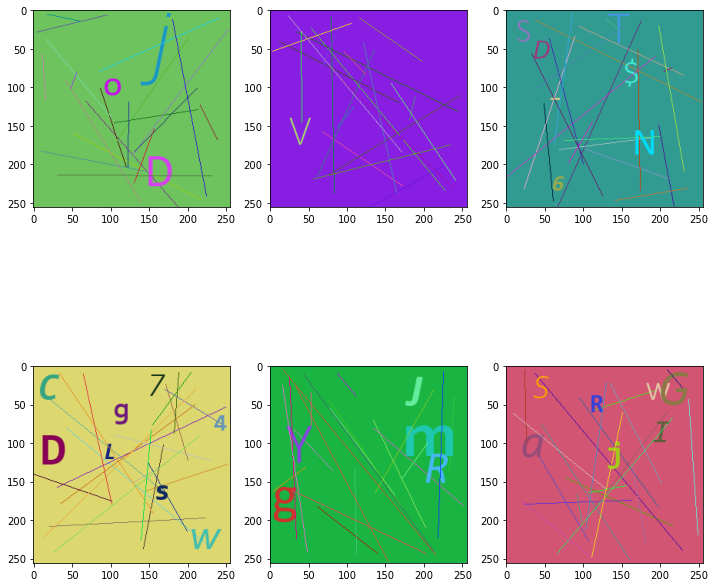

In [64]:
raws, columns = 2, 3
fig, axis = plt.subplots(raws, columns, figsize=(12, 12))
for i, img_path in enumerate(example_images):
    img_data = cv2.imread(img_path)
    axis[i % raws, i % columns].imshow(img_data)

## Building

Lets build our EfficientNet model. First we need to download all dependencies for it.

In [65]:
!pip install --no-deps '../input/timm-package/timm-0.1.26-py3-none-any.whl' > /dev/null
!pip install --no-deps '../input/pycocotools/pycocotools-2.0-cp37-cp37m-linux_x86_64.whl' > /dev/null

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [66]:
import sys
sys.path.insert(0, "../input/timm-efficientdet-pytorch")
sys.path.insert(0, "../input/omegaconf")

import torch
from datetime import datetime
import time
import random
import numpy as np
import albumentations as A
import matplotlib.pyplot as plt
from albumentations.pytorch.transforms import ToTensorV2
from sklearn.model_selection import StratifiedKFold
from torch.utils.data import Dataset,DataLoader
from torch.utils.data.sampler import SequentialSampler, RandomSampler
from glob import glob

SEED = 42

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(SEED)

print(f'{Fore.GREEN}everything was setup succsefully{Style.RESET_ALL}')

everything was setup succsefully


In [67]:
bboxs = np.stack(marking['bbox'].apply(lambda x: np.fromstring(x[1:-1], sep=' ')))
for i, column in enumerate(['x', 'y', 'w', 'h']):
    marking[column] = bboxs[:,i]
marking.drop(columns=['bbox'], inplace=True)

In [68]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

df_folds = marking[['image_id']].copy()
df_folds.loc[:, 'bbox_count'] = 1
df_folds = df_folds.groupby('image_id').count()
df_folds.loc[:, 'source'] = marking[['image_id', 'source']].groupby('image_id').min()['source']
df_folds.loc[:, 'stratify_group'] = np.char.add(
    df_folds['source'].values.astype(str),
    df_folds['bbox_count'].apply(lambda x: f'_{x // 15}').values.astype(str)
)
df_folds.loc[:, 'fold'] = 0

for fold_number, (train_index, val_index) in enumerate(skf.split(X=df_folds.index, y=df_folds['stratify_group'])):
    df_folds.loc[df_folds.iloc[val_index].index, 'fold'] = fold_number

In [69]:
def get_train_transforms():
    return A.Compose(
        [A.OneOf([
                    A.HueSaturationValue(hue_shift_limit=0.2, sat_shift_limit= 0.2, 
                                         val_shift_limit=0.2, p=0.9),
                    A.RandomBrightnessContrast(brightness_limit=0.2, 
                                               contrast_limit=0.2, p=0.9),
                    A.RandomGamma(p=0.9),
            ],p=0.25),
            A.OneOf([
                A.IAASharpen(alpha=(0.1, 0.3), p=0.5),
                A.CLAHE(p=0.8),
                #A.GaussNoise(var_limit=(10.0, 50.0), p=0.5),
                #A.GaussianBlur(blur_limit=3, p=0.5),
                A.ISONoise(color_shift=(0.01, 0.05), intensity=(0.1, 0.5), p=0.3),
            ], p=0.0),
            ToTensorV2(p=1.0),
        ], 
        p=1.0, 
        bbox_params=A.BboxParams(
            format='pascal_voc',
            min_area=0, 
            min_visibility=0,
            label_fields=['labels']
        )
    )


def get_valid_transforms():
    return A.Compose(
        [
            A.Resize(height=256, width=256, p=1.0),
            ToTensorV2(p=1.0),
        ], 
        p=1.0, 
        bbox_params=A.BboxParams(
            format='pascal_voc',
            min_area=0, 
            min_visibility=0,
            label_fields=['labels']
        )
    )

In [70]:
TRAIN_ROOT_PATH = TRAIN_IMGS_FOLDER
IMAGENET_DEFAULT_MEAN = [x * 255 for x in (0.485, 0.456, 0.406)]
IMAGENET_DEFAULT_STD = [x * 255 for x in (0.229, 0.224, 0.225)]

class DatasetRetriever(Dataset):

    def __init__(self, marking, image_ids, transforms=None, test=False):
        super().__init__()

        self.image_ids = image_ids
        self.marking = marking
        self.transforms = transforms
        self.test = test

    def __getitem__(self, index: int):
        image_id = self.image_ids[index]
        
        r = random.random()
        image, boxes = self.load_image_and_boxes(index)
        # there is only one class
        labels = torch.ones((boxes.shape[0],), dtype=torch.int64)
        
        target = {}
        target['boxes'] = boxes
        target['labels'] = labels
        target['image_id'] = torch.tensor([index])
        image = image.astype(np.uint8)

        if self.transforms:
            for i in range(10):
                sample = self.transforms(**{
                    'image': image,
                    'bboxes': target['boxes'],
                    'labels': labels
                })
                if len(sample['bboxes']) > 0:
                    image = sample['image']
                    target['boxes'] = torch.stack(tuple(map(torch.tensor, zip(*sample['bboxes'])))).permute(1, 0)
                    target['boxes'][:,[0,1,2,3]] = target['boxes'][:,[1,0,3,2]]  #yxyx: be warning
                    break
        image = image.float() / 255.0

        return image, target, image_id

    def __len__(self) -> int:
        return self.image_ids.shape[0]

    def load_image_and_boxes(self, index):
        image_id = self.image_ids[index]
        image = cv2.imread(f'{TRAIN_ROOT_PATH}/{image_id}.png', cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.uint8)
        #image = cv2.addWeighted(image, 4, cv2.GaussianBlur(image, (0,0) , 10), -4 ,128)
        #image = (image - IMAGENET_DEFAULT_MEAN) / IMAGENET_DEFAULT_STD
        records = self.marking[self.marking['image_id'] == image_id]
        boxes = records[['x', 'y', 'w', 'h']].values
        boxes[:, 2] = boxes[:, 0] + boxes[:, 2]
        boxes[:, 3] = boxes[:, 1] + boxes[:, 3]
        return image, boxes

    def load_mixup_iamge_and_boxes(self, index):
        image, boxes = self.load_image_and_boxes(index)
        r_image, r_boxes = self.load_image_and_boxes(random.randint(0, self.image_ids.shape[0] - 1))
        mixup_image = (image + r_image) / 2
        mixup_boxes = np.concatenate([boxes, r_boxes], axis=0)
        return mixup_image, mixup_boxes
        
    
    def load_cutmix_image_and_boxes(self, index, imsize=256):
        """ 
        This implementation of cutmix author:  https://www.kaggle.com/nvnnghia 
        Refactoring and adaptation: https://www.kaggle.com/shonenkov
        """
        w, h = imsize, imsize
        s = imsize // 2
    
        xc, yc = [int(random.uniform(imsize * 0.25, imsize * 0.75)) for _ in range(2)]  # center x, y
        indexes = [index] + [random.randint(0, self.image_ids.shape[0] - 1) for _ in range(3)]

        result_image = np.full((imsize, imsize, 3), 1, dtype=np.float32)
        result_boxes = []

        for i, index in enumerate(indexes):
            image, boxes = self.load_image_and_boxes(index)
            if i == 0:
                x1a, y1a, x2a, y2a = max(xc - w, 0), max(yc - h, 0), xc, yc  # xmin, ymin, xmax, ymax (large image)
                x1b, y1b, x2b, y2b = w - (x2a - x1a), h - (y2a - y1a), w, h  # xmin, ymin, xmax, ymax (small image)
            elif i == 1:  # top right
                x1a, y1a, x2a, y2a = xc, max(yc - h, 0), min(xc + w, s * 2), yc
                x1b, y1b, x2b, y2b = 0, h - (y2a - y1a), min(w, x2a - x1a), h
            elif i == 2:  # bottom left
                x1a, y1a, x2a, y2a = max(xc - w, 0), yc, xc, min(s * 2, yc + h)
                x1b, y1b, x2b, y2b = w - (x2a - x1a), 0, max(xc, w), min(y2a - y1a, h)
            elif i == 3:  # bottom right
                x1a, y1a, x2a, y2a = xc, yc, min(xc + w, s * 2), min(s * 2, yc + h)
                x1b, y1b, x2b, y2b = 0, 0, min(w, x2a - x1a), min(y2a - y1a, h)
            result_image[y1a:y2a, x1a:x2a] = image[y1b:y2b, x1b:x2b]
            padw = x1a - x1b
            padh = y1a - y1b

            boxes[:, 0] += padw
            boxes[:, 1] += padh
            boxes[:, 2] += padw
            boxes[:, 3] += padh

            result_boxes.append(boxes)

        result_boxes = np.concatenate(result_boxes, 0)
        np.clip(result_boxes[:, 0:], 0, 2 * s, out=result_boxes[:, 0:])
        result_boxes = result_boxes.astype(np.int32)
        result_boxes = result_boxes[np.where((result_boxes[:,2]-result_boxes[:,0])*(result_boxes[:,3]-result_boxes[:,1]) > 0)]
        return result_image, result_boxes

In [71]:
fold_number = 0

train_dataset = DatasetRetriever(
    image_ids=df_folds[df_folds['fold'] != fold_number].index.values,
    marking=marking,
    transforms=get_train_transforms(),
    test=False,
)

validation_dataset = DatasetRetriever(
    image_ids=df_folds[df_folds['fold'] == fold_number].index.values,
    marking=marking,
    transforms=get_valid_transforms(),
    test=True,
)

In [72]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [73]:
import warnings

warnings.filterwarnings("ignore")

class Fitter:
    
    def __init__(self, model, device, config):
        self.config = config
        self.epoch = 0

        self.base_dir = f'./{config.folder}'
        if not os.path.exists(self.base_dir):
            os.makedirs(self.base_dir)
        
        self.log_path = f'{self.base_dir}/log.txt'
        self.best_summary_loss = 10**5

        self.model = model
        self.device = device

        param_optimizer = list(self.model.named_parameters())
        no_decay = ['bias', 'LayerNorm.bias', 'LayerNorm.weight']
        optimizer_grouped_parameters = [
            {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)], 'weight_decay': 0.001},
            {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
        ] 

        self.optimizer = torch.optim.AdamW(self.model.parameters(), lr=config.lr)
        self.scheduler = config.SchedulerClass(self.optimizer, **config.scheduler_params)
        self.log(f'Fitter prepared. Device is {self.device}')

    def fit(self, train_loader, validation_loader):
        for e in range(self.config.n_epochs):
            if self.config.verbose:
                lr = self.optimizer.param_groups[0]['lr']
                timestamp = datetime.utcnow().isoformat()
                self.log(f'\n{timestamp}\nLR: {lr}')

            t = time.time()
            summary_loss = self.train_one_epoch(train_loader)

            self.log(f'[RESULT]: Train. Epoch: {self.epoch}, summary_loss: {summary_loss.avg:.5f}, time: {(time.time() - t):.5f}')
            self.save(f'{self.base_dir}/last-checkpoint.bin')

            t = time.time()
            summary_loss = self.validation(validation_loader)

            self.log(f'[RESULT]: Val. Epoch: {self.epoch}, summary_loss: {summary_loss.avg:.5f}, time: {(time.time() - t):.5f}')
            if summary_loss.avg < self.best_summary_loss:
                self.best_summary_loss = summary_loss.avg
                self.model.eval()
                self.save(f'{self.base_dir}/best-checkpoint-{str(self.epoch).zfill(3)}epoch.bin')
                for path in sorted(glob(f'{self.base_dir}/best-checkpoint-*epoch.bin'))[:-3]:
                    os.remove(path)

            if self.config.validation_scheduler:
                self.scheduler.step(metrics=summary_loss.avg)

            self.epoch += 1

    def validation(self, val_loader):
        self.model.eval()
        summary_loss = AverageMeter()
        t = time.time()
        for step, (images, targets, image_ids) in enumerate(val_loader):
            if self.config.verbose:
                if step % self.config.verbose_step == 0:
                    print(
                        f'Val Step {step}/{len(val_loader)}, ' + \
                        f'summary_loss: {summary_loss.avg:.5f}, ' + \
                        f'time: {(time.time() - t):.5f}', end='\r'
                    )
            with torch.no_grad():
                images = torch.stack(images)
                batch_size = images.shape[0]
                images = images.to(self.device).float()
                boxes = [target['boxes'].to(self.device).float() for target in targets]
                labels = [target['labels'].to(self.device).float() for target in targets]

                loss, _, _ = self.model(images, boxes, labels)
                summary_loss.update(loss.detach().item(), batch_size)

        return summary_loss
        
    def train_one_epoch(self, train_loader):
        self.model.train()
        summary_loss = AverageMeter()
        t = time.time()
        for step, (images, targets, image_ids) in enumerate(train_loader):
            if self.config.verbose:
                if step % self.config.verbose_step == 0:
                    print(
                        f'Train Step {step}/{len(train_loader)}, ' + \
                        f'summary_loss: {summary_loss.avg:.5f}, ' + \
                        f'time: {(time.time() - t):.5f}', end='\r'
                    )
            
            images = torch.stack(images)
            images = images.to(self.device).float()
            batch_size = images.shape[0]
            boxes = [target['boxes'].to(self.device).float() for target in targets]
            labels = [target['labels'].to(self.device).float() for target in targets]
            
            loss, _, _ = self.model(images, boxes, labels)
            loss = loss / float(self.config.grad_accumulation_steps)
            loss.backward()
            summary_loss.update(loss.detach().item(), batch_size)
            
            # Gradient accumulation
            if (step + 1) % self.config.grad_accumulation_steps == 0:
                self.optimizer.step()
                self.optimizer.zero_grad()
                if self.config.step_scheduler:
                    self.scheduler.step()

        return summary_loss
    
    def save(self, path):
        self.model.eval()
        torch.save({
            'model_state_dict': self.model.model.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
            'scheduler_state_dict': self.scheduler.state_dict(),
            'best_summary_loss': self.best_summary_loss,
            'epoch': self.epoch,
        }, path)

    def load(self, path):
        checkpoint = torch.load(path)
        self.model.model.load_state_dict(checkpoint['model_state_dict'])
        self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        self.scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
        self.best_summary_loss = checkpoint['best_summary_loss']
        self.epoch = checkpoint['epoch'] + 1
        
    def log(self, message):
        if self.config.verbose:
            print(message)
        with open(self.log_path, 'a+') as logger:
            logger.write(f'{message}\n')

In [74]:
class TrainGlobalConfig:
    num_workers = 2
    batch_size = 1
    n_epochs = 8 # n_epochs = 40
    lr = 0.001 # lr = 0.0002 # 0.001 recommended for Adam
    grad_accumulation_steps = 64

    folder = 'effdet6-cutmix-gradient-fold0'

    # -------------------
    verbose = True
    verbose_step = 1
    # -------------------

    # --------------------
    step_scheduler = False  # do scheduler.step after optimizer.step
    validation_scheduler = True  # do scheduler.step after validation stage loss

#     SchedulerClass = torch.optim.lr_scheduler.OneCycleLR
#     scheduler_params = dict(
#         max_lr=0.001,
#         epochs=n_epochs,
#         steps_per_epoch=int(len(train_dataset) / batch_size),
#         pct_start=0.1,
#         anneal_strategy='cos', 
#         final_div_factor=10**5
#     )
    
    SchedulerClass = torch.optim.lr_scheduler.ReduceLROnPlateau
    scheduler_params = dict(
        mode='min',
        factor=0.5,
        patience=2,
        verbose=False, 
        threshold=0.0001,
        threshold_mode='abs',
        cooldown=0, 
        min_lr=1e-8,
        eps=1e-08
    )
    # --------------------

In [75]:
def collate_fn(batch):
    return tuple(zip(*batch))

def run_training(path=''):
    device = torch.device('cuda:0')
    net.to(device)

    train_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=TrainGlobalConfig.batch_size,
        sampler=RandomSampler(train_dataset),
        pin_memory=False,
        drop_last=True,
        num_workers=TrainGlobalConfig.num_workers,
        collate_fn=collate_fn,
    )
    val_loader = torch.utils.data.DataLoader(
        validation_dataset, 
        batch_size=TrainGlobalConfig.batch_size,
        num_workers=TrainGlobalConfig.num_workers,
        shuffle=False,
        sampler=SequentialSampler(validation_dataset),
        pin_memory=False,
        collate_fn=collate_fn,
    )

    fitter = Fitter(model=net, device=device, config=TrainGlobalConfig)
    if path:
        fitter.load(path=path)
    fitter.fit(train_loader, val_loader)

In [76]:
from effdet import get_efficientdet_config, EfficientDet, DetBenchTrain
from effdet.efficientdet import HeadNet
import gc 

def get_net():
    config = get_efficientdet_config('tf_efficientdet_d5')
    net = EfficientDet(config, pretrained_backbone=False)
    config.num_classes = 1
    config.image_size = 256
    checkpoint = torch.load('../input/efficientdet/efficientdet_d5-ef44aea8.pth')
    net.load_state_dict(checkpoint)
    net.class_net = HeadNet(config, num_outputs=config.num_classes, norm_kwargs=dict(eps=.001, momentum=.01))
    
    #optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    del checkpoint
    gc.collect()
    
    return DetBenchTrain(net, config)

net = get_net()

In [77]:
run_training()

Fitter prepared. Device is cuda:0

2020-10-25T16:13:24.853920
LR: 0.001
[RESULT]: Train. Epoch: 0, summary_loss: 0.09949, time: 2742.34686
[RESULT]: Val. Epoch: 0, summary_loss: 0.50161, time: 286.78036

2020-10-25T17:03:56.212974
LR: 0.001
[RESULT]: Train. Epoch: 1, summary_loss: 0.00418, time: 2831.32945
[RESULT]: Val. Epoch: 1, summary_loss: 0.45678, time: 285.63652

2020-10-25T17:55:55.877390
LR: 0.001
[RESULT]: Train. Epoch: 2, summary_loss: 0.00268, time: 2838.27505
[RESULT]: Val. Epoch: 2, summary_loss: 0.40684, time: 281.44958

2020-10-25T18:47:57.955849
LR: 0.001
[RESULT]: Train. Epoch: 3, summary_loss: 0.00209, time: 2837.06185


KeyboardInterrupt: 